# Assignment 1 - Introduction to PyG

This assignment will test basic control over the PyG and NetworkX module which are commonly used to implement Geometric Deep Learning.

## Some Setup

In [8]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 68.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set3")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set3")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

## Section 1 - Graph Creation (5 points)

### Question 1.1 (2 points)
Create the following graph in PyG. The numbers inside the squares are both the ID and the values stored in the notes. This is a directed graph, with only 1 edge being undirected. Feel free to use any method to generate this, as long as the resulting Data object is the same.


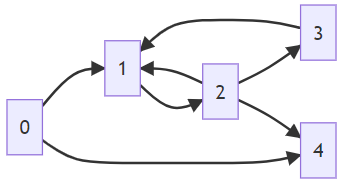

In [9]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 0, 1, 2, 2, 2, 3],
                           [1, 4, 2, 1, 3, 4, 1]], dtype=torch.long)
x = torch.tensor([[0], [1], [2], [3], [4]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

### Question 1.2 (1 point)
Complete the code to visualise the graph using the utilities module of PyG to make a networkx Graph object which can be drawn using the draw_networkx function. The helper function visualize_graph takes the name of your object as the parameter, along with a color parameter that you can choose as per your will.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


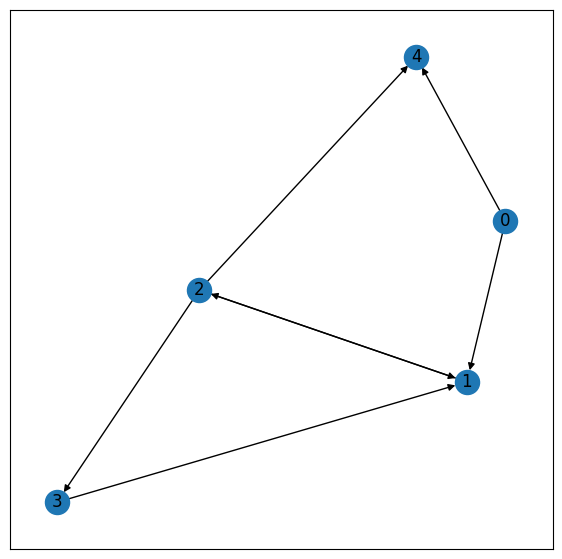

In [10]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=False)

visualize_graph(G, color=data.y)

### Question 1.3 (2 points)

It seems like I made a mistake when creating the graph above. Modify the same graph to add these features in. You can make the changes to the networkx object itself -


*   A node with id 5
*   An edge starting from 1 going to 5
*   An edge starting from 5 going to 0
*   A two-way edge between 2 and 5

In [11]:
G.add_node(5)
G.add_edges_from([(1,5),(5,0),(2,5),(5,2)])

Run the below cell to visualize your graph

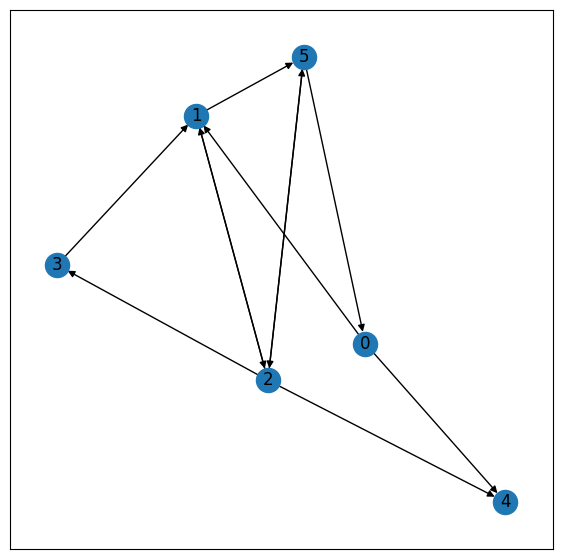

In [12]:
visualize_graph(G, color=data.y)

## Section 2 - Graph Properties and Manipulation (15 points)

The questions in this section are based on the MUTAG dataset imported below. For each question, write code that can return out the desired property of the graph



In [13]:
from torch_geometric.datasets import TUDataset

mutag_datasets = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
mutag = mutag_datasets[0]

Extracting /tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


### Question 2.1 (2 points)
Fill out this function that can return a tuple containing the simple properties of this graph - number of nodes (int), edges (int), node features (int), and directedness (bool), as a tuple -

`(#nodes, #edges, #features, directedness)`

In [14]:
def get_basic_chars(dataset):
  ### Your Code Here
  nodes = dataset.num_nodes
  edges = dataset.num_edges
  features = dataset.num_node_features
  drtds = dataset.is_directed()
  chars = (nodes,edges,features,drtds)
  return chars

get_basic_chars(mutag)

(42, 162, 3, False)

### Question 2.2 (1 point)
Does this graph have any self loops? What about isolated nodes?

In [15]:
def addn_props(dataset):
  self_obsessed = dataset.has_self_loops()
  loners = dataset.has_isolated_nodes()
  return (self_obsessed, loners)

addn_props = addn_props(mutag)
print(f'Does this graph have self loops? {addn_props[0]}')
print(f'Does this graph have isolated nodes? {addn_props[1]}')

Does this graph have self loops? False
Does this graph have isolated nodes? False


In [16]:
from torch_geometric.utils import to_networkx

G = to_networkx(mutag,to_undirected=False)

### Question 2.3 (2 points)
Compute the average degree of this network, rounded to the nearest integer.

In [17]:
def avg_degree(G):
  nodes = len(G.nodes)
  edges = len(G.edges)
  avg_deg = edges/nodes
  return avg_deg

avg_deg = avg_degree(G)
print(f'Average degree of MUTAG is {avg_deg:.3f}')

Average degree of MUTAG is 3.857


### Question 2.3 (2 points)

Randomly split this dataset into train-val-test sets in the ratio 75-15-10, ie. 75% training, 15% validation, 10% testing.

**Note**: The dataset is split into a different train-val-test ratio already, you'll have to combine them and resplit them again to get the desired split.

In [18]:
G = to_networkx(mutag, to_undirected=True)
########################################

import random
tot_ind = list(range(len(mutag_datasets)))
random.shuffle(tot_ind)
train_split = int(0.75 * len(tot_ind))
val_split = int(0.90 * len(tot_ind))

train,val,test = mutag_datasets[tot_ind[:train_split]],mutag_datasets[tot_ind[train_split:val_split]],mutag_datasets[tot_ind[val_split:]]
########################################

### Question 2.4 (8 points)

Reference on small-world networks - [Small-world network](https://www.wikiwand.com/en/Small-world_network)

1. Calculate the sigma and omega coefficients for small-worldness by directly calling the inbuilt library functions of networkx
2. Calculate the sigma and omega coefficients for small-worldness by finding the values of c, c_r, l, l_r, c_l etc.
3. Time both the methods and compare the time taken. Is it taking too long? Try calculating the average clustering coefficient yourself from the dictionary obtained by clustering, does that help? Why?

> Bonus : Explanation for the improvement in time when calculating average manually. Explanation for why the values computed manually and by the library don't match (2+2 points)


In [19]:
import time

In [20]:
direct_start = time.time()
sigma = nx.sigma(G)
omega = nx.omega(G)
direct_end = time.time()

def calc_sig_omg(G):
  c = nx.average_clustering(G)
  l = nx.average_shortest_path_length(G)
  R = nx.random_reference(G)
  L = nx.lattice_reference(G)
  c_L = nx.average_clustering(L)
  c_R = nx.average_clustering(R)
  l_L = nx.average_shortest_path_length(L)
  l_R = nx.average_shortest_path_length(R)
  sig = (c/c_R)/(l/l_R)
  omg = (l_R/l) - (c/c_L)
  return (sig,omg)
conv_start = time.time()
sig,omg = calc_sig_omg(G)
conv_end = time.time()

print(f'Direct Sigma Coefficient: {sigma}')
print(f'Direct Omega Coefficient: {omega}')
print(f'Time for Direct Method: {direct_end - direct_start}')
print(f'Conv Sigma Coefficient: {sig}')
print(f'Conv Omega Coefficient: {omg}')
print(f'Time for Conv Method: {conv_end - conv_start}')


Direct Sigma Coefficient: 2.779625656871813
Direct Omega Coefficient: -0.4762502706213466
Time for Direct Method: 109.6961874961853
Conv Sigma Coefficient: 2.561483953674491
Conv Omega Coefficient: -1.4336403313604125
Time for Conv Method: 0.5777237415313721


## Section 3 - The Clustering Coefficient (10 points)
This section is theoretical, you need to submit a proof/derivation/expression for each question as stated.

> Bonus: Taking the effort to use LaTeX/any good typesetting in your derivation will get you a bonus 5 points for Q3

You have already seen the global clustering coefficient in action in the lecture slides. Let's now however talk about the local clustering coefficient. The local clustering coefficient for a vertex is the proportion of links between the vertices of its neighbourhood divided by the number of links that could possibly exist between them.

We define a **wedge** as an ordered triplet of edges, which share exactly one common node, called the centre of the wedge.
We call a wedge complete if the edge between the two ends of the wedge exist, completing the triangle.

We denote the number of wedges centred at a vertex $i$ by $k_i$.

You may have noticed by now that we can probably define the clustering coefficient in terms of $k_i$ and the adjacency matrix of the graph $A$. Your first task -


#### Q3.1 Derive an expression for the local clustering coefficient $C_i$ of a vertex $i$ for an undirected graph in terms of the adjacency matrix $A$ and $k_i$. (3 points)

$$C_i = \frac{T_i}{k_i(k_i-1)}~$$
,where $$k_i = \sum_{j} A_{ij}$$, the degree of the node
 and $$T_i = \sum_{j,k} A_{ij}A_{jk}A_{ki}$$

The global clustering coefficient based on this concept of a wedge would simply be the fraction of closed wedges in the entire network.
#### Q3.2 Derive the expression to calculate the global clustering coefficient $C$ of the entire network. (4 points)

> Assume naturally, that the network only has finitely many nodes.

$$C = \frac{6T}{\sum_{i}k_i(k_i - 1)}$$
where $$T = ∑_{i,j,h} A_{ij}A_{jh}A_{hi}$$, number of triangles in the network

Finally let's turn this concept on its head. Instead of measuring the local clustering coefficient in terms of closed wedges on a centre, we'll measure about the head (or end) of the wedge.

Define the **back-in-2 coefficient, $Bi_2(i)$** as the fraction of wedges, *headed* at $i$ that are closed.
#### Q3.3 Write down the expression for the $Bi_2$ coefficient of a vertex $i$ in terms of adjacency matrices only (3 points)

$$Bi_2(i) = \frac{2T_i}{(\sum_{y \in N(i)}k_y) - k_i }$$
where $N(i)$ is the neighbourhood of vertex $i$

> ### Bonus: Find the more common standard name for the Bi_2 coefficient. (2 points)

Local Closure Coefficient